In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load your final cleaned dataset
df = pd.read_csv('2018_hmda_processed.csv')

In [3]:
# Separate features and target
X = df.drop(columns=['action_taken'])  # 'action_taken' is the binary target
X = X.drop(columns=['applicant_age_above_62']) # redundant data that is causing type error
X = X.drop(columns=['reverse_mortgage'])
X= X.drop(columns=['open_end_line_of_credit'])
X = X.drop(columns = ['race', 'applicant_sex', 'census_tract', 'county_code', 'ethnicity']) # remove sensitive/bias info

y = df['action_taken']

In [4]:
print(X.shape)
print(y.shape)

(894700, 35)
(894700,)


In [5]:
X.isnull().sum()

Unnamed: 0                                  0
activity_year                               0
conforming_loan_limit                       0
preapproval                                 0
loan_purpose                                0
business_or_commercial_purpose              0
loan_amount                                 0
interest_rate                               0
hoepa_status                                0
loan_term                                   0
interest_only_payment                       0
balloon_payment                             0
other_nonamortizing_features                0
property_value                              0
occupancy_type                              0
manufactured_home_secured_property_type     0
manufactured_home_land_property_interest    0
total_units                                 0
income                                      0
applicant_credit_score_type                 0
applicant_age                               0
submission_of_application         

In [6]:
# One-hot encode categorical variables (if any)
# X = pd.get_dummies(X, drop_first=True)

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [8]:
# Initialize and train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [9]:
# Predictions
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

Accuracy: 0.7260198949368504
F1 Score: 0.817997549838512
ROC AUC Score: 0.7881808178848329

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.69      0.45     28627
           1       0.93      0.73      0.82    150313

    accuracy                           0.73    178940
   macro avg       0.63      0.71      0.63    178940
weighted avg       0.83      0.73      0.76    178940



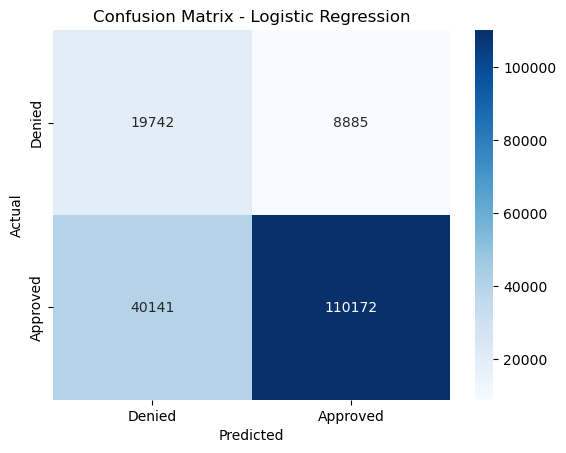

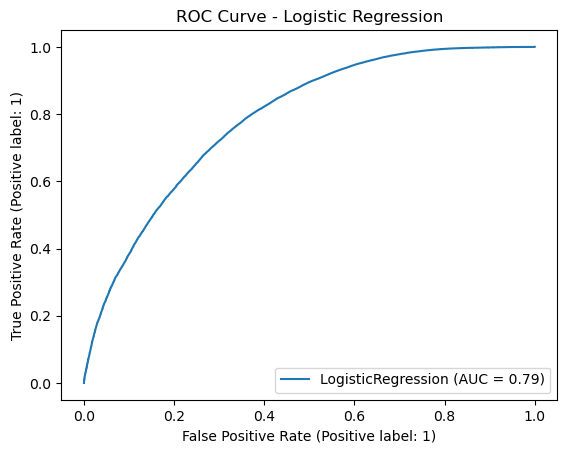

In [10]:

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Denied', 'Approved'], yticklabels=['Denied', 'Approved'])
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()


In [11]:
def demographic_parity(group_col, privileged_value):
    privileged = df[df[group_col] == privileged_value]
    unprivileged = df[df[group_col] != privileged_value]

    # Use the model to predict on all X (must match df rows)
    preds = log_reg.predict(X)

    privileged_preds = preds[privileged.index]
    unprivileged_preds = preds[unprivileged.index]

    privileged_positive_rate = privileged_preds.mean()
    unprivileged_positive_rate = unprivileged_preds.mean()

    dp_diff = unprivileged_positive_rate - privileged_positive_rate
    di_ratio = unprivileged_positive_rate / privileged_positive_rate if privileged_positive_rate != 0 else np.nan

    print(f"\nFairness Metrics for '{group_col}' (privileged = {privileged_value}):")
    print(f"  Demographic Parity Difference: {dp_diff:.4f}")
    print(f"  Disparate Impact Ratio: {di_ratio:.4f}")

# Example: check bias based on race (using 'White' as privileged group)
demographic_parity('race', privileged_value=1)

# Example: check bias based on sex (using 'Male' as privileged group)
demographic_parity('applicant_sex', privileged_value=1)


Fairness Metrics for 'race' (privileged = 1):
  Demographic Parity Difference: -0.3400
  Disparate Impact Ratio: 0.6299

Fairness Metrics for 'applicant_sex' (privileged = 1):
  Demographic Parity Difference: -0.1611
  Disparate Impact Ratio: 0.7820


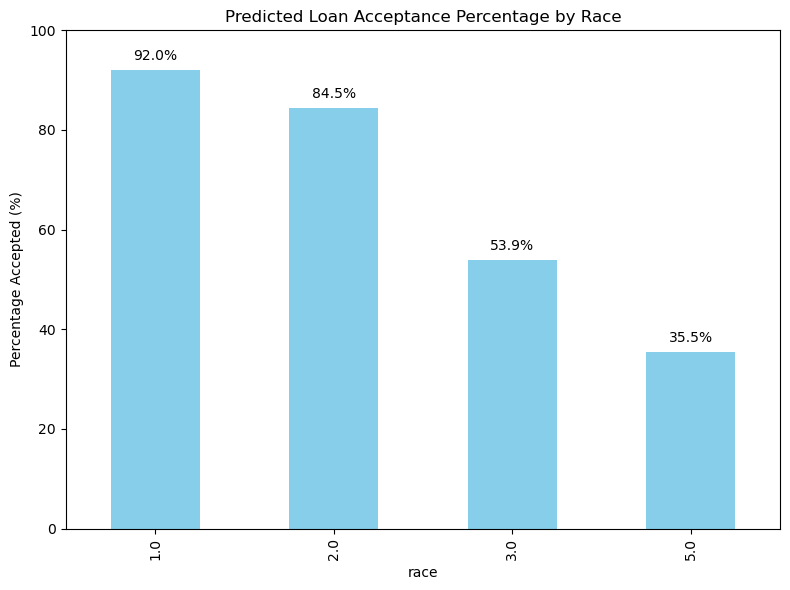

In [12]:


# Assume df is your original DataFrame containing the 'race' column.
# X_test is the DataFrame used for testing (its index corresponds to rows in df).
# y_pred is an array or Series containing the model predictions (1 for accepted, 0 for denied).

# Step 1: Merge the predictions with the original DataFrame.
df.loc[X_test.index, 'predicted_action_taken'] = y_pred
df_test = df.loc[X_test.index].copy()

# Step 2: Group by the race column and calculate the acceptance percentage.
# Since accepted loans are coded as 1, the mean gives the acceptance rate.
accepted_percentage = df_test.groupby('race')['predicted_action_taken'].mean() * 100

# Step 3: Create a bar plot for the acceptance percentages.
fig, ax = plt.subplots(figsize=(8, 6))
accepted_percentage.plot(kind='bar', color='skyblue', ax=ax)

ax.set_ylabel("Percentage Accepted (%)")
ax.set_title("Predicted Loan Acceptance Percentage by Race")
ax.set_ylim(0, 100)

# Add percentage labels above each bar.
for i, percentage in enumerate(accepted_percentage):
    ax.text(i, percentage + 2, f"{percentage:.1f}%", ha='center')

plt.tight_layout()
plt.show()